# Advanced Statistics for Quantitative Trading
<div class="alert alert-info"><strong>Part II : Time Series Modeling with Python</strong></div>

## Draft Version (Final version will be uploaded in a couple of days)
### *Everything until the topic Testing for stationarity is complete. The remaining parts are incomplete or in draft form.*
#### Notebook Created on: 6 July 2020
##### Last Update: 9 Jul 2020
##### Version 1.0
##### Author: Vivek Krishnamoorthy

## **Agenda for today**
- Anatomy of a time series process
- Modeling time series using decomposition
    - Method I: `statsmodels` library
    - Method II: `fbprophet` library
- Testing for stationarity
- Modeling time series using
    - Method III: Exponential smoothing
    - Method IV: ARIMA 
- Analyzing stock return volatility with ARCH/GARCH models

<a id = 'convert'></a>

### Anatomy of a time series process

It is helpful to consider a time series process as a combination of *systematic* and *unsystematic* components.

- **Systematic**: These are recurring in nature and so can be described and modeled.
- **Non-systematic**: These are random in nature and so cannot be directly modeled.

The systematic components can be further split into *level*, *trend*, and *seasonality* whereas the non-systematic component is referred to as *noise*.

- **Level**: The average value of the process.
- **Trend**: The direction and rate of change of the process. The slope is a good proxy for it.
- **Seasonality**: Deviations in the process caused by recurring short-term cycles.
- **Noise**: The random variation observed in the process.

Another useful abstraction while analyzing time series processes is to see them as either an *additive* or a *multiplicative* blend of the four constituent parts mentioned.

**Additive model**: The process $X(t)$ has the form
$$X(t) = Level + Trend + Seasonality + Noise$$

We use an additive model when the underlying process under examination has the following characteristics.
- The process changes remain constant over time (i.e. they are linear). So the trend line would be straight.
- It shows linear seasonality. That is to say the frequency and amplitude (i.e. the width and the height) of the cycles remain constant over time.



**Multiplicative model**: The process $X(t)$ has the form
$$X(t) = Level \times Trend \times Seasonality \times Noise$$

We use a multiplicative model when the underlying process under examination has the following characteristics.
- The process changes vary over time (i.e. they are non-linear in nature).
- An exponential or quadratic or higher order polynomial process is multiplicative. So the trend-line would be curved, not straight. 
- It shows non-linear seasonality. That is to say the frequency and amplitude (i.e. the width and the height) of the cycles vary over time.

In the (harsh) real world, we often encounter non-linear or even mixed processes and therefore have to work with the multiplicative model as our prototype. But we prefer to work with linear processes as they are easier to use. So we transform the original process into a linear one. A commonly used trick is applying a log transformation.

### Modelling a time series using decomposition

There are several available libraries (ex. [`statsmodels`](https://www.statsmodels.org/stable/tsa.html), [`fbprophet`](https://facebook.github.io/prophet/docs/quick_start.html), [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), [`PyFlux`](https://pyflux.readthedocs.io/en/latest/), [`fecon236`](https://github.com/MathSci/fecon236), [`PM-Prophet`](https://github.com/luke14free/pm-prophet) at the time of this writing) in Python to develop sophisticated time series models for forecasting. 

We work with `statsmodels` and `fbprophet` here. Both offer convenient routines to automatically decompose a time series into their fundamental components.

We will work with the daily crude oil (from 2003 to 2020) and soy bean (from 2000 to 2020) price series.

We first try the `seasonal_decompose` method from the `statsmodels.tsa` sub-library and then experiment with the `fbprophet` library.

#### Method I : Seasonal decomposition using the `seasonal_decompose` routine in `statsmodels` 

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import quandl
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

In [2]:
file = open("quandl_apikey.txt",'r')

In [3]:
#############################################################################
################### TO STUDENTS: PLEASE IGNORE THIS CELL ####################
#############################################################################

## I do the below procedure so as to not show my API key.
## You can choose to ignore it.

filename = "quandl_apikey.txt"

def get_file_contents(filename):
    """ If provided a filename,
        this function returns the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # We create a file containing a single line,
            # with our Quandl API key
            return f.read().strip()
    except FileNotFoundError:
        print(f"{filename} file not found")

quandl_key = get_file_contents(filename)

## Garbled characters appear at the start of my API key, hence the below step
#quandl_key = quandl_key[3:]

quandl.ApiConfig.api_key = quandl_key
quandl_key

'wmsfiRzidebSsrcv2Ro1'

In [4]:
#############################################################################
################### TO STUDENTS: PLEASE RUN THIS CELL #######################
#############################################################################

## If you have installed quandl and created a free account there, you would have an API key.
## Please copy-paste below as shown and replace YOURAPIKEY with your key from quandl.
## Then uncomment the below line and run the cell.
# quandl.ApiConfig.api_key = "YOURAPIKEY"

In [5]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv("crude_oil_prices.csv")
# df4 = pd.read_csv("crude_oil_prices.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [6]:
start4 = '2003-01-01'
end4 = '2020-07-05'
ticker4 = "OPEC/ORB"

In [7]:
## ***********************************************************
## ***** EXPERIMENTAL : IGNORE THIS CELL *********************
## Trials with other commodity data
## ***********************************************************

# "OPEC/ORB" this is crude oil prices per barrel
# WGC/GOLD_DAILY_INR for daily gold prices in India available until 10 March 2020
# TFGRAIN/SOYBEANS for daily soy bean prices per bushel
# WORLDAL/PALPROD primary aluminium production across continents. not tried.

In [8]:
df = quandl.get(dataset=ticker4, start_date=start4, end_date=end4)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker4} data")

Downloaded 4515 rows and 1 columns of OPEC/ORB data


In [9]:
df4 = df.copy()

In [10]:
print(df4.head(10))
print(df4.tail())

            Value
Date             
2003-01-02  30.05
2003-01-03  30.83
2003-01-06  30.71
2003-01-07  29.72
2003-01-08  28.86
2003-01-09  29.51
2003-01-10  29.82
2003-01-13  29.82
2003-01-14  30.21
2003-01-15  30.66
            Value
Date             
2020-06-29  37.34
2020-06-30  38.22
2020-07-01  42.69
2020-07-02  42.93
2020-07-03  42.96


In [11]:
df4.rename(columns={'Value': 'price'}, inplace=True)

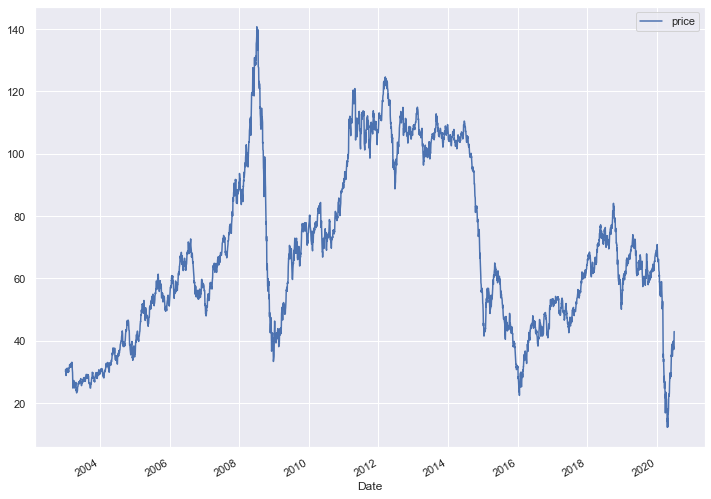

In [12]:
df4.plot(figsize=(12, 9))

Points to note:
- There are upward and downward trends in the prices. Looks linear. Needs further probing.
- There seems to be seasonality and we can investigate further by looking at some moving averages.

In [13]:
window_length = 21 # for 1 monthly moving average calculations
window_length2 = 252 # for annual moving average calculations

## Calculating 21-day rolling mean and volatility

df4['rolling_21d_mean'] = df4['price'].rolling(window=window_length).mean()
df4['rolling_21d_vol'] = df4['price'].rolling(window=window_length).std()


## Calculating 252-day rolling mean and volatility

df4['rolling_12m_mean'] = df4['price'].rolling(window=window_length2).mean()
df4['rolling_12m_vol'] = df4['price'].rolling(window=window_length2).std()

Text(0, 0.5, 'Price per barrel (in US$)')

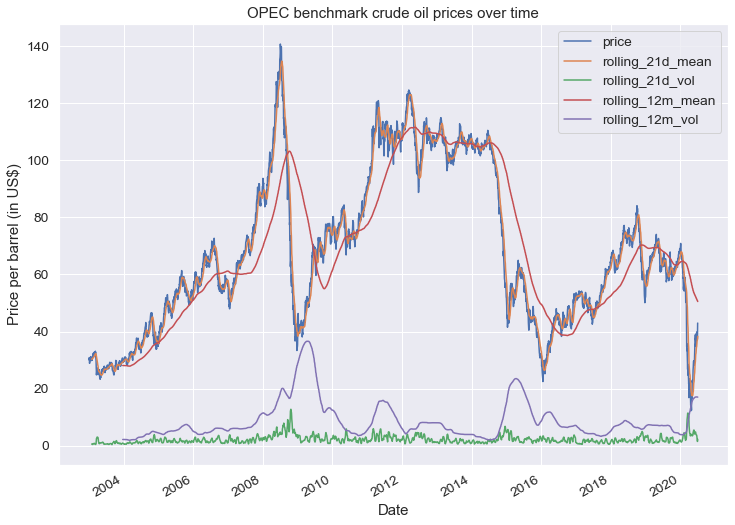

In [14]:
sns.set(font_scale=1.25)
df4.plot(figsize=(12, 9))

plt.title("OPEC benchmark crude oil prices over time")
plt.xlabel("Date")
plt.ylabel("Price per barrel (in US$)")

Points to note:
- The yearly moving average of the prices show a linear trend (which changes roughly every couple of years).
- The monthly moving price average shows seasonality.
- The rolling volatility is time-varying in both (monthly and annual) cases.
- Let's try using the **multiplicative** model.

In [15]:
df4.shape

(4515, 5)

In [16]:
df4.index

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-29', '2020-06-30', '2020-07-01',
               '2020-07-02', '2020-07-03'],
              dtype='datetime64[ns]', name='Date', length=4515, freq=None)

In [17]:
## Method I: Using statsmodels

decompose_series = seasonal_decompose(df4['price'], period=252, model="multiplicative")

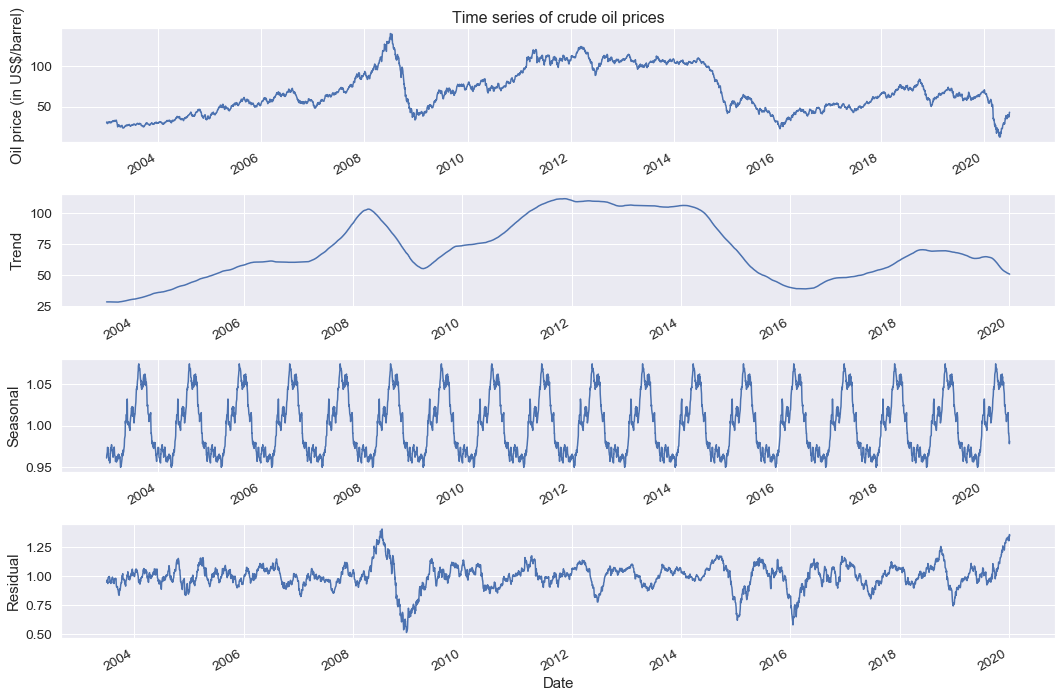

In [18]:
fig, ax = plt.subplots(4, 1, figsize=(15, 10))

decompose_series.observed.plot(ax=ax[0])
ax[0].set_title("Time series of crude oil prices", fontsize=16)
ax[0].set(xlabel="", ylabel="Oil price (in US$/barrel)")

decompose_series.trend.plot(ax=ax[1])
ax[1].set(xlabel="", ylabel="Trend")

decompose_series.seasonal.plot(ax=ax[2])
ax[2].set(xlabel="", ylabel="Seasonal")

decompose_series.resid.plot(ax=ax[3])
ax[3].set(xlabel="Date", ylabel="Residual")

plt.tight_layout()

Points to note:
- The plot shows us the observed, trend, seasonal and residual time series. We can access each component by typing: `decompose_series.trend`, `decompose_series.seasonal`, and `decompose_series.residual` 
- The trend and seasonal plots that have been extracted from the original series look plausible.
- The residual plot clearly has non-constant volatility. If the model was a suitable fit, then after taking out the trend and seasonality present in the price data, we would have residuals that do not have any discernable pattern. Not so here.
- At this stage, we would evaluate alternatives to model the residuals. We could even consider exogenous variables like oil production, renewable energy investments, etc. which would influence oil prices (outside the scope of this session).
- From the `statsmodels` documentation: *This is a naive decomposition. More sophisticated methods should be preferred.*

#### Method II : Seasonal decomposition using Facebook's Prophet library `fbprophet` 

In [19]:
## Method II: Using fbprophet
## Working with the soy bean price series

from fbprophet import Prophet

In [20]:
start5 = '2000-12-01'
end5 = '2020-02-29'
ticker5 = "TFGRAIN/SOYBEANS"

In [21]:
df = quandl.get(dataset=ticker5, start_date=start5, end_date=end5)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker5} data")

Downloaded 4820 rows and 4 columns of TFGRAIN/SOYBEANS data


In [22]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv("soy_bean_prices.csv")
# df4 = pd.read_csv("soy_bean_prices.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [23]:
df.head()

,Cash Price,Basis,Fall Price,Fall Basis
Date,,,,
2000-12-01,4.90,-0.18,5.02,-0.26
2000-12-04,4.87,-0.18,4.99,-0.26
2000-12-05,4.83,-0.18,4.98,-0.26
2000-12-06,4.89,-0.18,5.02,-0.26
2000-12-07,4.85,-0.18,4.98,-0.26


In [24]:
df.tail()

,Cash Price,Basis,Fall Price,Fall Basis
Date,,,,
2020-02-24,8.61,-0.13,8.69,-0.36
2020-02-25,8.66,-0.13,8.75,-0.36
2020-02-26,8.77,-0.13,8.77,-0.36
2020-02-27,8.74,-0.12,8.78,-0.36
2020-02-28,8.72,-0.12,8.72,-0.36


In [25]:
df5 = df.copy()

In [26]:
df5.shape

(4820, 4)

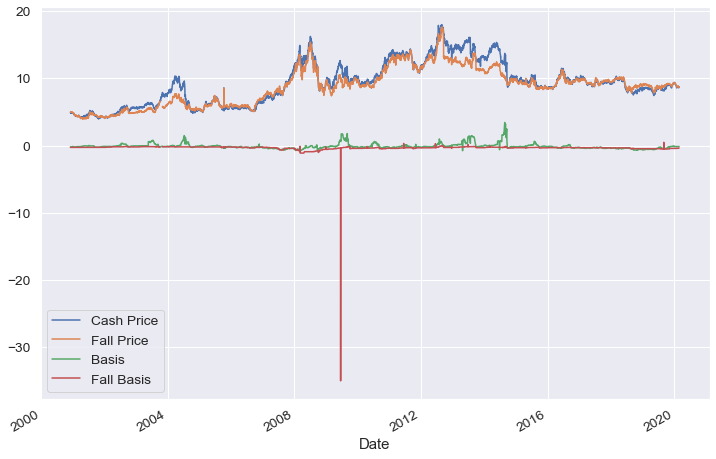

In [27]:
df5[['Cash Price', 'Fall Price', 'Basis', 'Fall Basis']].plot(figsize=(12, 8))

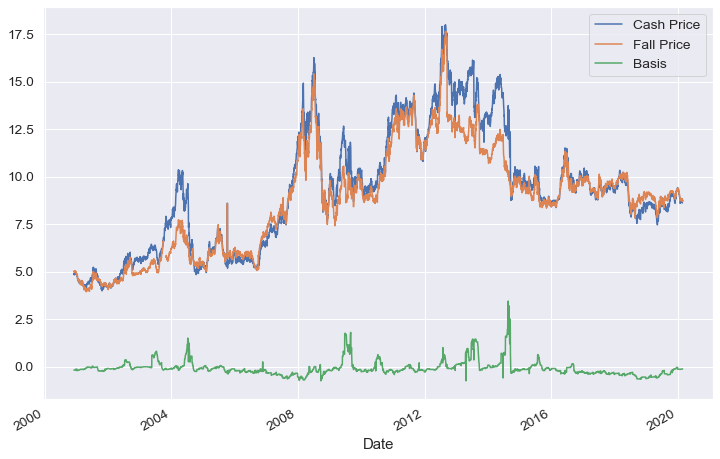

In [28]:
df5[['Cash Price', 'Fall Price', 'Basis']].plot(figsize=(12, 8))

Points to note:
- We will only work with `Cash Price` for the forecasting. There are both increasing and decreasing trends in the cash prices.
- Since soy bean grains are an agricultural commodity, we see seasonality through the year.

In [29]:
df5.drop(columns=['Basis', 'Fall Price', 'Fall Basis'], inplace=True)

In [30]:
## Following the DataFrame manipulation procedure and further steps
## as recommended in Facebook's Prophet documentation
df5.reset_index(drop=False, inplace=True)
df5.rename(columns={'Date': 'ds', 'Cash Price': 'y'}, inplace=True)

In [31]:
## We split the data into train and test sets (this is the language of machine learning)
## In the language of econometrics, we would call them in-sample and out-of-sample
## Here, we choose the index for the training data set

train_index = df5['ds'].apply(lambda x: x.year) < 2019

In [32]:
## Creating the training set

df5_train = df5.loc[train_index]

In [33]:
## Checking for NaNs

df5_train.isna().sum()

ds    0
y     0
dtype: int64

In [34]:
df5_train.head(), df5_train.tail()

(          ds     y
 0 2000-12-01  4.90
 1 2000-12-04  4.87
 2 2000-12-05  4.83
 3 2000-12-06  4.89
 4 2000-12-07  4.85,
              ds     y
 4523 2018-12-24  8.29
 4524 2018-12-26  8.15
 4525 2018-12-27  8.14
 4526 2018-12-28  8.28
 4527 2018-12-31  8.32)

In [35]:
## Creating the testing set

df5_test = df5.loc[~train_index].reset_index(drop=True)

In [36]:
df5_test.head(), df5_test.tail()

(          ds     y
 0 2019-01-02  8.44
 1 2019-01-03  8.50
 2 2019-01-04  8.59
 3 2019-01-07  8.61
 4 2019-01-08  8.56,
             ds     y
 287 2020-02-24  8.61
 288 2020-02-25  8.66
 289 2020-02-26  8.77
 290 2020-02-27  8.74
 291 2020-02-28  8.72)

In [37]:
df5.shape, df5_train.shape, df5_test.shape

((4820, 2), (4528, 2), (292, 2))

In [38]:
%%time
## Instantiating the Prophet model
## By default, it is 'additive'.
## On your own time, you can try 'multiplicative' while reviewing the material
model1 = Prophet(seasonality_mode='additive')

Wall time: 913 ms


In [39]:
%%time
## Additional specification that our data has monthly seasonality
## Other arguments have been set as per the documentation
model1.add_seasonality(name='monthly', period=30.5, fourier_order=5)

## The below method is similar to the scikit-learn library's fit().
## The model is fitted using the training data specified earlier.
model1.fit(df5_train)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Wall time: 19.8 s


In [40]:
%%time

df5_future = model1.make_future_dataframe(periods=425)
df5_pred = model1.predict(df5_future)

Wall time: 2.5 s


In [41]:
df5_future.shape

(4953, 1)

In [42]:
df5_future.head(10)

,ds
0,2000-12-01
1,2000-12-04
2,2000-12-05
3,2000-12-06
4,2000-12-07
5,2000-12-08
6,2000-12-11
7,2000-12-12
8,2000-12-13
9,2000-12-14


In [43]:
df5_future.tail(10)

,ds
4943,2020-02-20
4944,2020-02-21
4945,2020-02-22
4946,2020-02-23
4947,2020-02-24
4948,2020-02-25
4949,2020-02-26
4950,2020-02-27
4951,2020-02-28
4952,2020-02-29


In [44]:
df5_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4948,2020-02-25,8.995392,6.399169,11.626583,6.470039,11.489715,0.070864,0.070864,0.070864,0.007981,...,-0.067682,-0.067682,-0.067682,0.130565,0.130565,0.130565,0.0,0.0,0.0,9.066256
4949,2020-02-26,8.995062,6.357424,11.590165,6.472701,11.484429,0.043722,0.043722,0.043722,-0.028277,...,-0.062892,-0.062892,-0.062892,0.134891,0.134891,0.134891,0.0,0.0,0.0,9.038784
4950,2020-02-27,8.994732,6.335975,11.639966,6.476024,11.479142,0.015051,0.015051,0.015051,-0.055217,...,-0.067947,-0.067947,-0.067947,0.138215,0.138215,0.138215,0.0,0.0,0.0,9.009782
4951,2020-02-28,8.994401,6.295660,11.651020,6.453931,11.473856,0.011061,0.011061,0.011061,-0.055820,...,-0.073719,-0.073719,-0.073719,0.140601,0.140601,0.140601,0.0,0.0,0.0,9.005462
4952,2020-02-29,8.994071,6.729364,12.093769,6.431392,11.468569,0.480868,0.480868,0.480868,-0.032867,...,0.371610,0.371610,0.371610,0.142125,0.142125,0.142125,0.0,0.0,0.0,9.474939


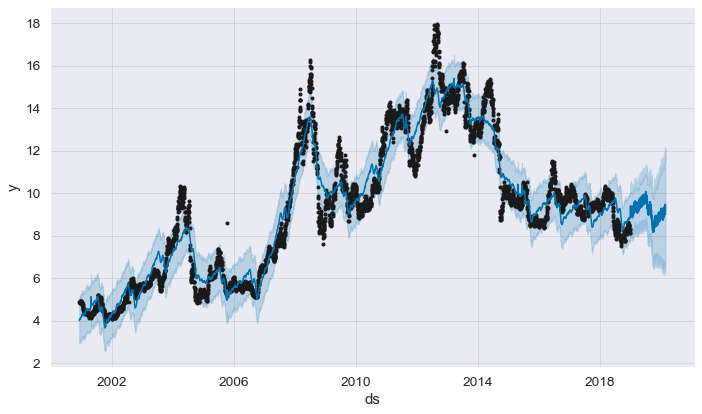

In [45]:
## Plotting the predicted values on testing and training data

model1.plot(df5_pred);

Points to note:
- The model's predicted values (blue line) approximately follow the observed soy bean prices (black dots).
- The light blue shadow is the confidence interval for the predicted values. Its width changes over time and quantifies our confidence in the point estimates.
- Visually we see that whenever there's a sharp change in prices, the model fails to predict correctly.

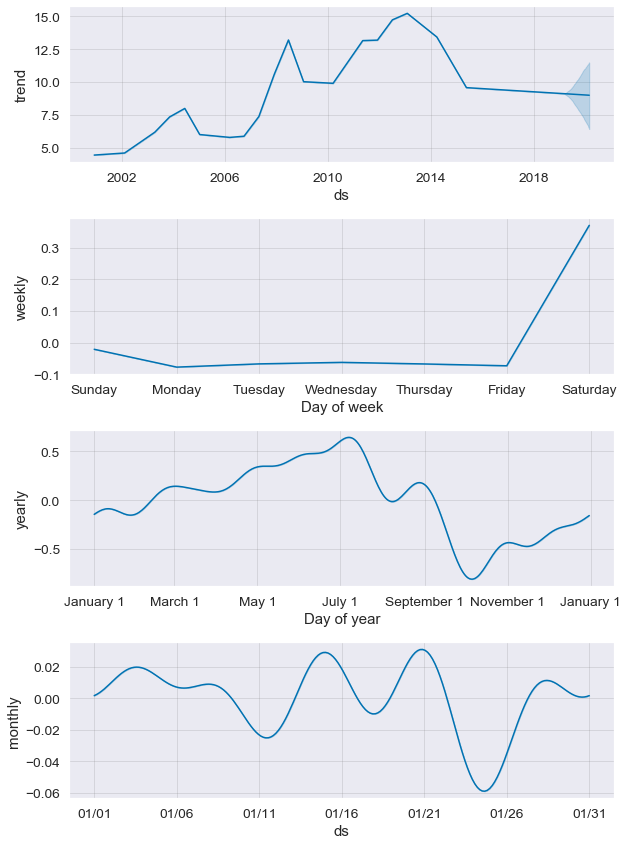

In [46]:
model1.plot_components(df5_pred);

Points to note:
- The overall trend shows an increase in cash prices over the entire time period.
- In the weekly plot, we ignore the prices on weekends (no trading). The prices through the week are quite constant (i.e. no day-of-the-week effect).
- In the yearly plot, there's a wide range of prices (of ~US\$ 1 with a high in July and a low in October) observed across the year. We would expect to see seasonality in an agricultural commodity like soy beans (month-of-the=-year effect).
- In the monthly plot, we see some variance but the scale is much smaller than in the previous plot.

In [47]:
%%time
## We create a merged DataFrame to examine the actuals v/s predicted values closely

selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']
df5_pred = df5_pred.loc[:, selected_columns].reset_index(drop=True)

## Using left join, we only select rows that are part of our testing data set.
## This would exclude the predictions on holidays and weekends.

df5_test = df5_test.merge(df5_pred, on=['ds'], how='left')

Wall time: 7.82 ms


In [48]:
df5_test['ds'] = pd.to_datetime(df5_test['ds'])

In [49]:
df5_test.set_index('ds', inplace=True)

Wall time: 205 ms


[Text(0, 0.5, 'Price per bushel (US$)'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Soy bean price - actual vs. predicted')]

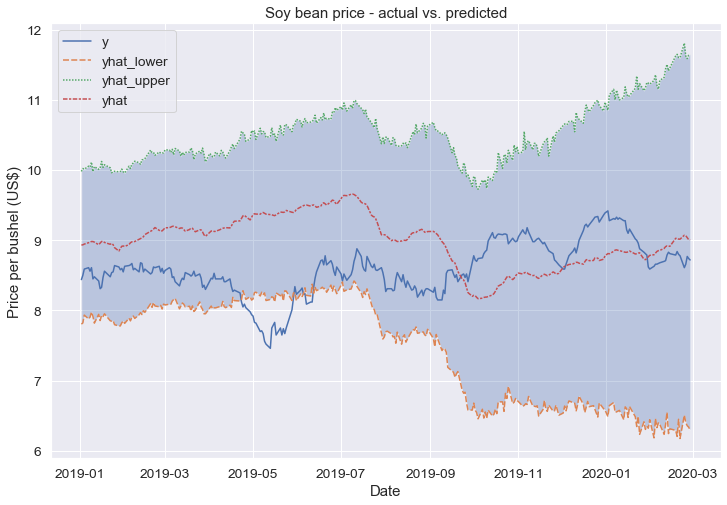

In [50]:
%%time

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.lineplot(data=df5_test[['y', 'yhat_lower', 
                                 'yhat_upper', 'yhat']])
ax.fill_between(df5_test.index, df5_test.yhat_lower, 
                df5_test.yhat_upper, alpha=0.3)
ax.set(title='Soy bean price - actual vs. predicted', 
       xlabel='Date', ylabel='Price per bushel (US$)')

Points to note:
- The interval estimate of the soy bean price prediction appears to have been accurate for the whole period (except a month in May 2019).
- The confidence interval in the last six months is wider than in the initial period.

### Checking for stationarity

There are three ways of checking for stationarity in a time series.
1. Visual inspection
2. Statistical tests
3. ACF/PACF plots

We prefer working with stationary time series processes because it makes modeling, analysis and forecasting more feasible.

For this section, we work with daily gold prices in India. The prices shown are denominated in INR per ounce.

In [51]:
start6 = '1995-01-01'
end6 = '2020-02-29'
ticker6 = "WGC/GOLD_DAILY_INR"

In [52]:
df = quandl.get(dataset=ticker6, start_date=start6, end_date=end6)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker6} data")

Downloaded 6565 rows and 1 columns of WGC/GOLD_DAILY_INR data


In [53]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv("gold_prices_inr.csv")
# df4 = pd.read_csv("gold_prices_inr.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [54]:
df.head()

,Value
Date,
1995-01-02,12022.09
1995-01-03,11948.83
1995-01-04,11781.62
1995-01-05,11771.27
1995-01-06,11769.08


In [55]:
df.tail()

,Value
Date,
2020-02-24,120360.88
2020-02-25,118624.63
2020-02-26,117158.98
2020-02-27,118243.96
2020-02-28,116178.85


In [56]:
df6 = df.copy()

In [57]:
df6.rename(columns={"Value": "price"}, inplace=True)

In [58]:
df6.tail()

,price
Date,
2020-02-24,120360.88
2020-02-25,118624.63
2020-02-26,117158.98
2020-02-27,118243.96
2020-02-28,116178.85


In [59]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sms
from statsmodels.tsa.stattools import adfuller

In [60]:
def check_stationarity(y, wl1=21, wl2=252, lags=40, figsize=(15, 10)):
    """ Checks the stationarity of a pandas Series,
        using plots, correlograms and the ADF test
    """
    ## Calculating rolling statistics
    
    rolling_wl1_mean = y.rolling(window=wl1).mean()
    rolling_wl2_mean = y.rolling(window=wl2).mean()
    rolling_wl1_vol = y.rolling(window=wl1).std()
    rolling_wl2_vol = y.rolling(window=wl2).std()
    
    ## Plotting the price, rolling statistics and correlograms
    
    fig = plt.figure(figsize=figsize)
    sns.set(font_scale=1)
    layout = (2, 2)
    y_ax = plt.subplot2grid(layout, (0, 0))
    vol_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=y_ax)
    rolling_wl1_mean.plot(ax=y_ax)
    rolling_wl2_mean.plot(ax=y_ax)
    
    rolling_wl1_vol.plot(ax=vol_ax)
    rolling_wl2_vol.plot(ax=vol_ax)
    y_ax.set_title('Rolling means over time')
    y_ax.legend(['observed', f'{wl1}-day MA of observed', f'{wl2}-day MA of observed'], loc='best')
    #y_ax.set_ylabel("Gold prices(in INR)/oz.")
    
    vol_ax.set_title('Rolling volatility over time')
    vol_ax.legend([f'{wl1}-day MA of volatility', f'{wl2}-day MA of volatility'], loc='best')
    
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
    
    ## Running the Augmented Dickey-Fuller test
    print('--------------------------------------------------------------')
    print('--------- The augmented Dickey-Fuller test results -----------')
    print('--------------------------------------------------------------')
    adftest = adfuller(y, autolag='AIC')
    results = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags','# of Observations'])
    for key,value in adftest[4].items():
        results[f'Critical Value ({key})'] = '{0:.3f}'.format(value)
    print(results)
    print('--------------------------------------------------------------')

In [61]:
check_stationarity?

Signature: check_stationarity(y, wl1=21, wl2=252, lags=40, figsize=(15, 10))
Docstring:
Checks the stationarity of a pandas Series,
using plots, correlograms and the ADF test
File:      d:\algotrading\quantinsti course\10. advanced statistics for quant strategies\asq-02-files\<ipython-input-60-56b21e741725>
Type:      function


--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic           1.10185
p-value                 0.995232
# of Lags                     32
# of Observations           6532
Critical Value (1%)       -3.431
Critical Value (5%)       -2.862
Critical Value (10%)      -2.567
dtype: object
--------------------------------------------------------------


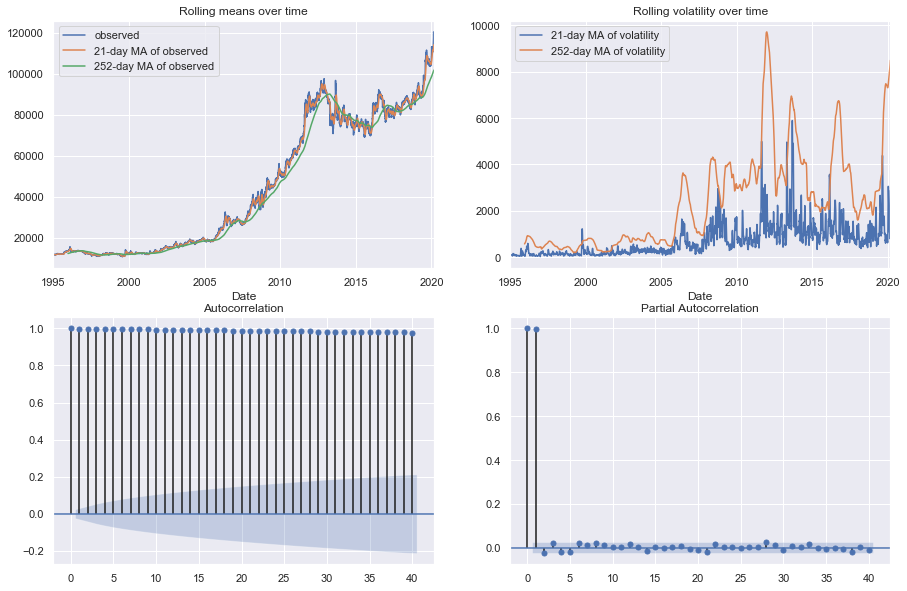

In [62]:
check_stationarity(df6['price'])

Points to note:
- In the ADF test, if the test statistic is greater than the critical value, we conclude that the series is non-stationary. We can draw the same conclusion by examining the p-value. A p-value greater than our significance level (conventionally 5%) means we cannot reject our null hypothesis (The series is not stationary). 
- For the gold prices, we have a p-value of nearly 1 (and equivalently the test statistic is greater than the critical values at all 3 significance levels), so we conclude that the price series is not stationary.
- The rolling means and volatility plots are time-varying. So we also conclude visually that gold prices in India are non-stationary.
- From the ACF, there are significant autocorrelations above the 95% confidence interval at all lags. From the PACF, we have significance in autocorrelations at lags 1, 2, 3, 6, and 8.

In [63]:
df6['log_returns'] = np.log(df6['price'] / df6['price'].shift(1))
df6.dropna(axis='rows', how='any', inplace=True)

--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic             -17.4701
p-value                 4.54757e-30
# of Lags                        26
# of Observations              6537
Critical Value (1%)          -3.431
Critical Value (5%)          -2.862
Critical Value (10%)         -2.567
dtype: object
--------------------------------------------------------------


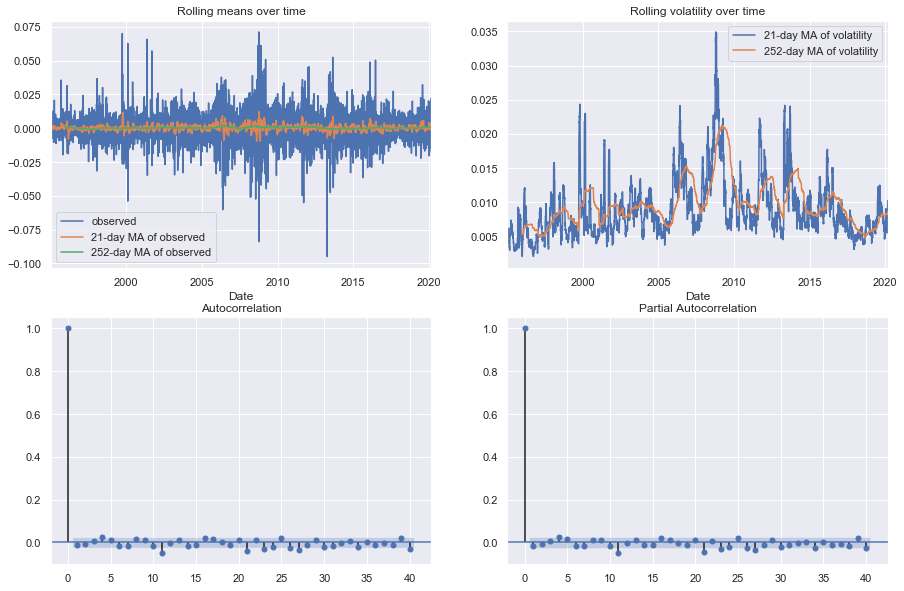

In [64]:
check_stationarity(df6['log_returns'])

Points to note:
- As per the ADF test results, the returns of gold are stationary since the p-value is almost 0 and the test statistic is less than all the critical values.
- The returns and rolling means of the returns are all centred around 0. As the time scale increases, the means become more and more constant. At shorter time scales, the noise tends to obscure the signal.
- The volatily is time-varying at both the faster and slower rolling levels.
- There is a little spike in the ACF plot at lags 3, 11, and 21.

#### Method III : Modeling time series using exponential smoothing

This method works well with non-stationary data. It is similar to the exponential moving averages in that higher weights are assigned to more recent data. It is an alternative to the ARIMA class of methods (which we will explore later).

In exponential smoothing, the forecasts are a weighted sum of past observations wherein the weights decrease exponentially as we move further into the past.

##### 1. Simple Exponential Smoothing

- Most suited for a series that do not exhibit any trend or seasonality
- We use a smoothing factor, $\alpha$, to set the rate at which the weight assigned to past observations decay. It takes a value between $0$ and $1$. The higher the value of $\alpha$, the more weight is assigned to recent observations.

##### 2. Double Exponential Smoothing (a.k.a. Holt's Linear Trend Method)

- Extension of the SES method to account for trend (but not seasonality) in a time series 

We now look at implementing exponential smoothing and forecasting on the Asian Paints stock.
> *Asian Paints Limited, together with its subsidiaries, manufactures, sells, and distributes paints and coatings for decorative and industrial use in India and internationally. It operates in the Paints and Home Improvement segments.* - [Yahoo Finance](https://finance.yahoo.com/quote/ASIANPAINT.NS/profile?p=ASIANPAINT.NS).



In [76]:
end7 = datetime.date(2020, 6, 30)
start7 = datetime.date(2010, 7, 1)
ticker7 = "ASIANPAINT.NS"

In [77]:
df = yf.download(ticker7, start=start7, end=end7, progress=False)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker7} data")

Downloaded 2460 rows and 6 columns of ASIANPAINT.NS data


In [78]:
#############################################################################
################# PLEASE USE BELOW STATEMENTS IF NEEDED #####################
#############################################################################

## If you have don't have quandl, you can read the csv file as shown.

# mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z")
# df.to_csv(f"{ticker7}.csv")
# df4 = pd.read_csv("gold_prices_inr.csv", index_col=0, parse_dates=True)
# df1 = pd.read_csv("NSE_5min_interval.csv", index_col=0, parse_dates=True, date_parser=mydateparser)

In [79]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-07-01,232.994995,233.800003,227.529999,232.975006,159.086273,465110
2010-07-02,233.994995,235.779999,231.199997,232.080002,158.475098,294440
2010-07-05,233.000000,234.970001,231.699997,232.955002,159.072586,104120
2010-07-06,233.000000,235.199997,232.554993,234.520004,160.141235,193200
2010-07-07,234.520004,236.399994,232.119995,233.675003,159.564240,379790


In [80]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-23,1659.849976,1689.000000,1641.000000,1683.900024,1682.410400,2334863
2020-06-24,1684.000000,1813.750000,1684.000000,1747.250000,1745.704346,11545923
2020-06-25,1740.000000,1747.000000,1683.150024,1689.000000,1687.505981,4054785
2020-06-26,1710.000000,1710.349976,1670.699951,1686.750000,1685.257935,2129986
2020-06-29,1687.000000,1708.449951,1674.050049,1691.949951,1690.453247,2753482


In [81]:
df7 = df.copy()

In [82]:
df7.drop(columns=["Open", "High", "Low", "Close", "Volume"], inplace=True)
df7.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df7.tail())

              adj_close
Date                   
2020-06-23  1682.410400
2020-06-24  1745.704346
2020-06-25  1687.505981
2020-06-26  1685.257935
2020-06-29  1690.453247


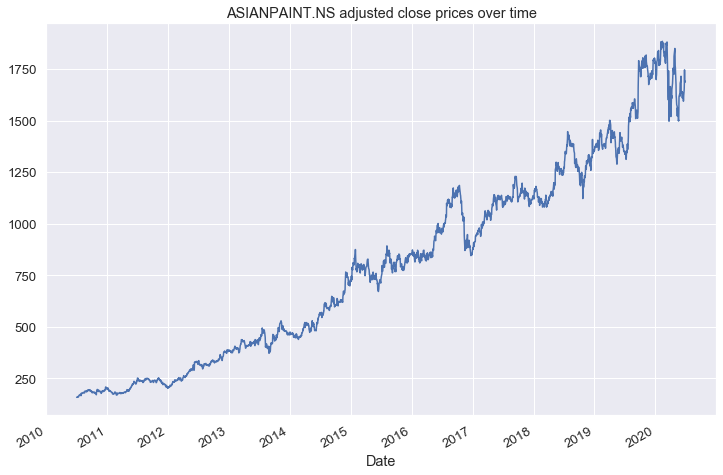

In [83]:
sns.set(font_scale=1.2)
df7['adj_close'].plot(figsize=(12, 8), title=f"{ticker7} adjusted close prices over time")

In [84]:
df7.shape

(2460, 1)

In [85]:
## Creating the training & testing set

train_length = int(np.round(0.9 * df7.shape[0]))
df7_train = df7.iloc[:train_length]
df7_test = df7.iloc[train_length:]
test_length = len(df7_test)

NameError: name 'ses_forecast_1' is not defined

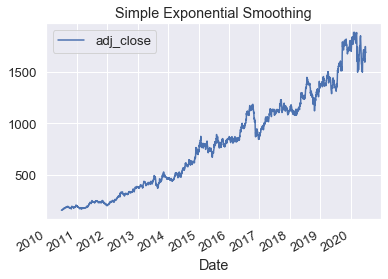

In [86]:
df7.plot(title='Simple Exponential Smoothing', label='Actual', legend=True)

ses_forecast_1.plot(legend=True, label=r'$\alpha=0.2$')
ses_1.fittedvalues.plot()

ses_forecast_2.plot(legend=True, label=r'$\alpha=0.5$')
ses_2.fittedvalues.plot()

ses_forecast_3.plot(legend=True, label=r'$\alpha={0:.4f}$'.format(alpha))
ses_3.fittedvalues.plot()

plt.tight_layout()
plt.show()

In [ ]:
%%time

## Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

## Creating the SES model class
ses_model = SimpleExpSmoothing(df7_train)

## Fitting models at different smoothing levels
ses_fit_1 = ses_model.fit(smoothing_level=0)
ses_fit_2 = ses_model.fit(smoothing_level=0.25)
ses_fit_3 = ses_model.fit(smoothing_level=0.75)
ses_fit_4 = ses_model.fit()
alpha = ses_fit_4.model.params['smoothing_level']

## Forecasting
ses_fit_1_yhat = ses_fit_1.forecast(test_length)
ses_fit_2_yhat = ses_fit_2.forecast(test_length)
ses_fit_3_yhat = ses_fit_3.forecast(test_length)
ses_fit_4_yhat = ses_fit_4.forecast(test_length)

In [ ]:
ses_fit_1_yhat.head()

In [ ]:
## Plotting the results

df7.plot(title='Simple Exponential Smoothing', label='Actual', legend=True)


<a id = 'references'></a>
#### References
<a id = 'bnshephard'></a>
<a id = 'arch'></a>
<a id = 'others'></a>
<a id = 'eryk'></a>
<a id = 'cont2001'></a>

1. Barndorff‐Nielsen, O. E., & Shephard, N. (2002). Econometric analysis of realized volatility and its use in estimating stochastic volatility models. *Journal of the Royal Statistical Society: Series B (Statistical Methodology)*, 64(2), 253-280.
2. Cochrane, John H. "Time series for macroeconomics and finance." Manuscript, University of Chicago (2005).
3. Cont, R.(2001). Empirical properties of asset returns: stylized facts and statistical issues.
4. https://towardsdatascience.com/@eryk.lewinson
5. https://pyflux.readthedocs.io/en/latest/getting_started.html
6. https://tomaugspurger.github.io/modern-7-timeseries
7. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html
6. Tsay, Ruey S. Analysis of financial time series. Vol. 543. John Wiley & Sons, 2005.
7. Campbell, John Y., Andrew Wen-Chuan Lo, and Archie Craig MacKinlay. The Econometrics of Financial Markets. Vol. 2. Princeton, NJ: princeton University press, 1997.